In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

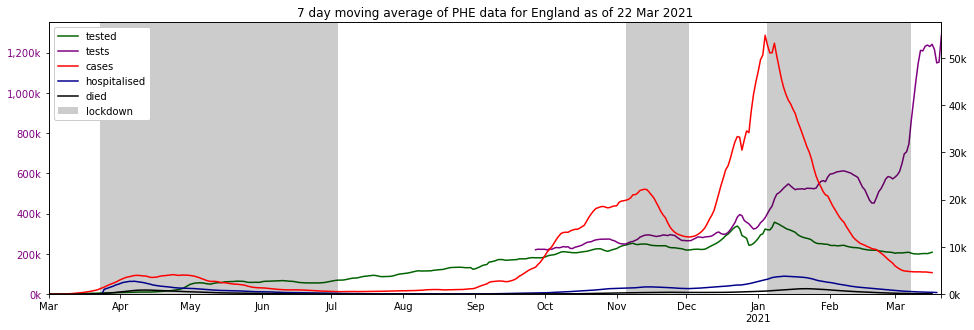

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

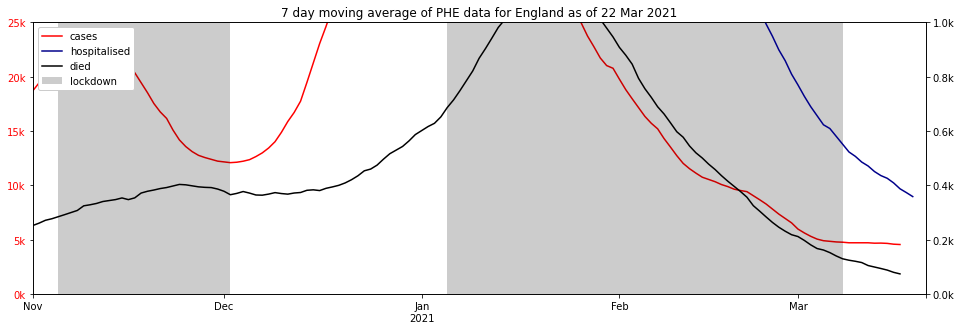

In [3]:
plot_summary(earliest_date='2020-11-01',
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,1621547.0,23854862.0,22233315.0,56286961,2.880857,39.499939,57.619204
1,Northern Ireland,N92000002,88683.0,687528.0,598845.0,1893667,4.683136,31.623564,63.693300
2,Scotland,S92000003,225096.0,2182400.0,1957304.0,5463300,4.120147,35.826405,60.053448
3,Wales,W92000004,346058.0,1273186.0,927128.0,3152879,10.975937,29.405759,59.618304


'partial: 27,997,976 (41.9%), full: 2,281,384'

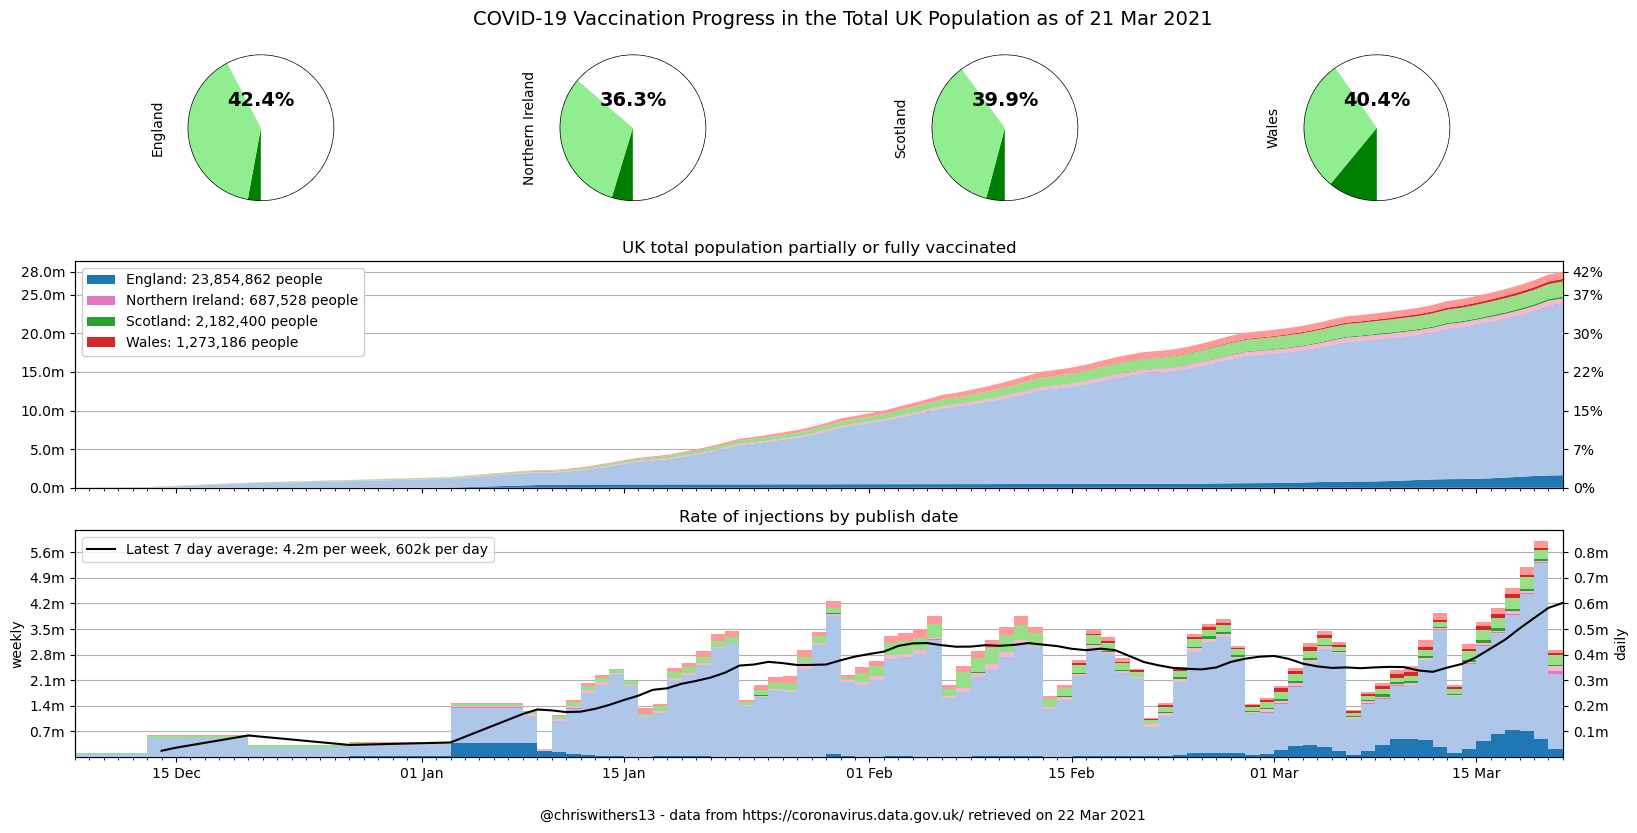

In [4]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,21 Mar 21,"+295,359","+30,418","+30,418","+23,854,862","+1,621,547","+1,621,547"
Northern Ireland,21 Mar 21,"+19,770","+10,187","+10,187","+687,528","+88,683","+88,683"
Scotland,21 Mar 21,"+37,460","+4,908","+4,908","+2,182,400","+225,096","+225,096"
Wales,21 Mar 21,"+14,417","+7,099","+7,099","+1,273,186","+346,058","+346,058"


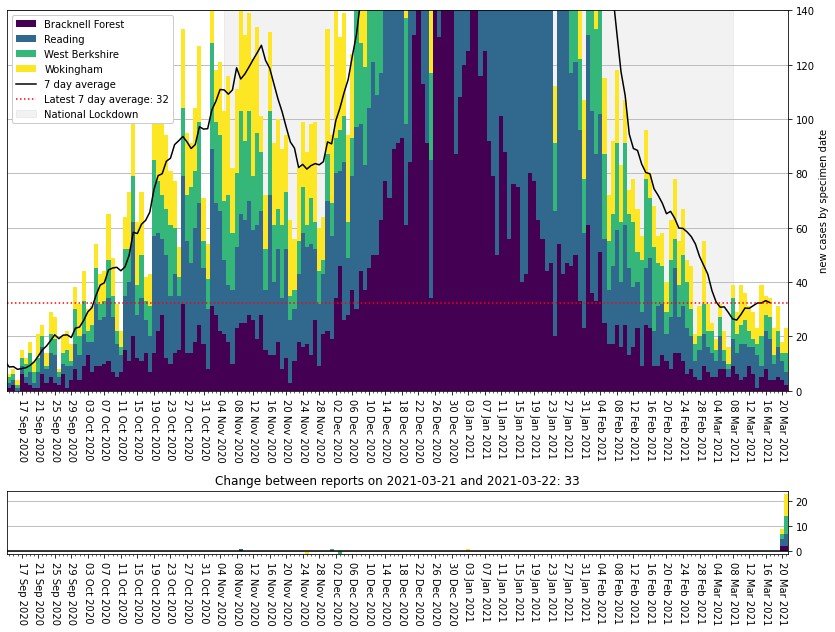

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140, show_testing=False)

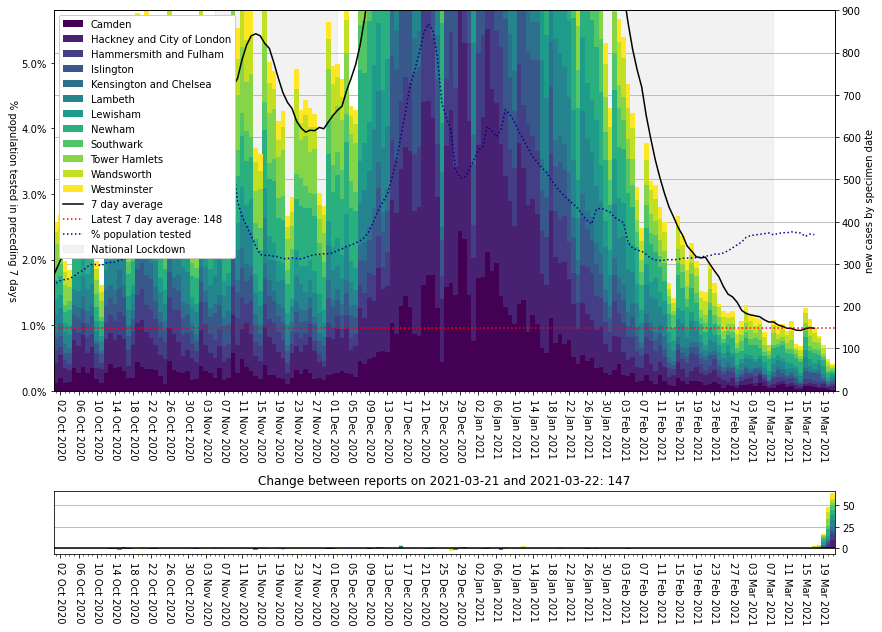

In [7]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,185.549309,134.0,2021-03-21
S12000040,West Lothian,180.229383,330.0,2021-03-21
E08000016,Barnsley,167.297238,413.0,2021-03-21
E06000013,North Lincolnshire,146.263320,252.0,2021-03-21
E07000236,Redditch,144.262910,123.0,2021-03-21
E06000010,"Kingston upon Hull, City of",135.500312,352.0,2021-03-21
E08000032,Bradford,128.201328,692.0,2021-03-21
E08000018,Rotherham,128.103206,340.0,2021-03-21
E08000017,Doncaster,124.723460,389.0,2021-03-21


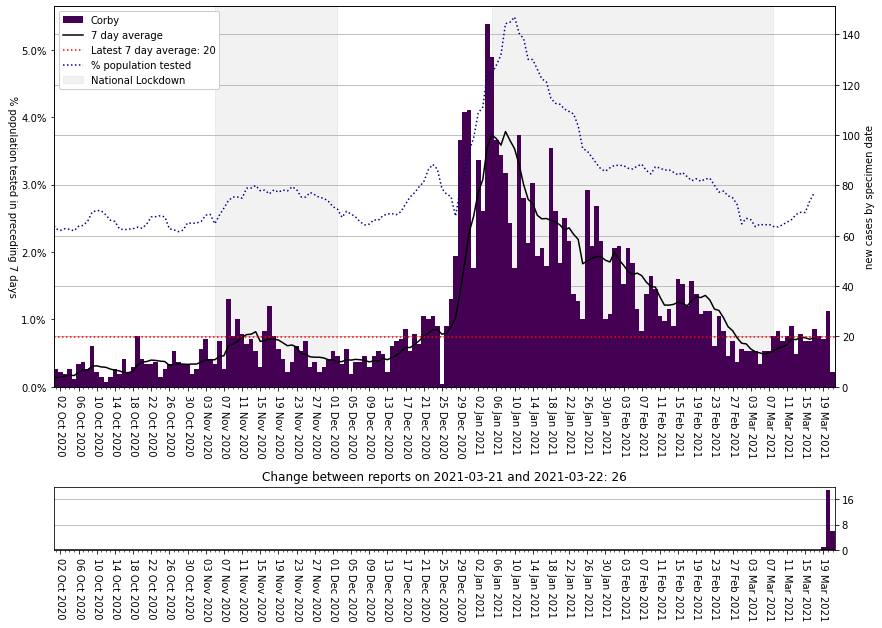

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,65.684839,750.0,2021-03-21
E08000035,Leeds,90.652458,719.0,2021-03-21
E08000032,Bradford,128.201328,692.0,2021-03-21
E08000019,Sheffield,113.874769,666.0,2021-03-21
S12000049,Glasgow City,101.876422,645.0,2021-03-21
E08000036,Wakefield,122.878339,428.0,2021-03-21
E08000003,Manchester,77.415901,428.0,2021-03-21
E08000016,Barnsley,167.297238,413.0,2021-03-21
E08000034,Kirklees,92.544800,407.0,2021-03-21


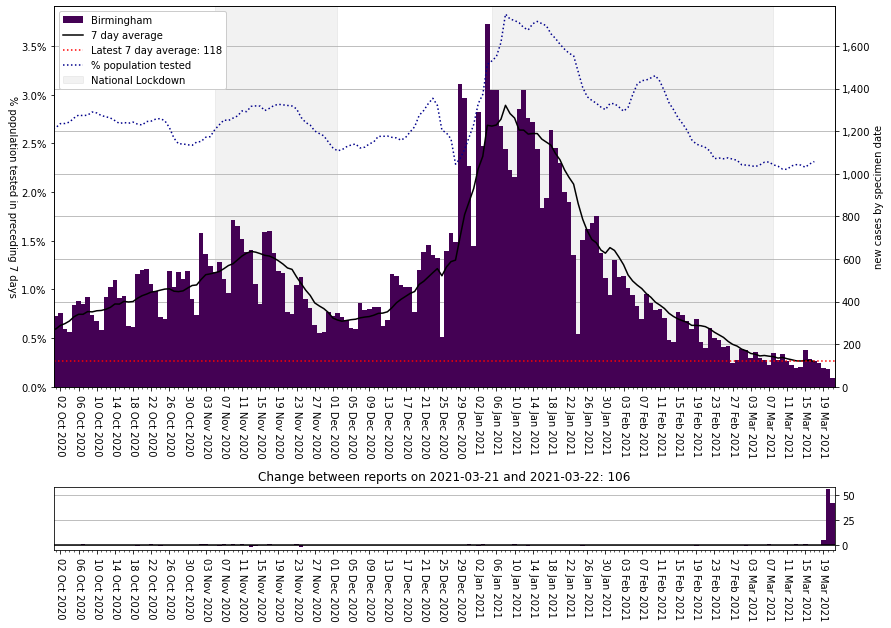

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.2

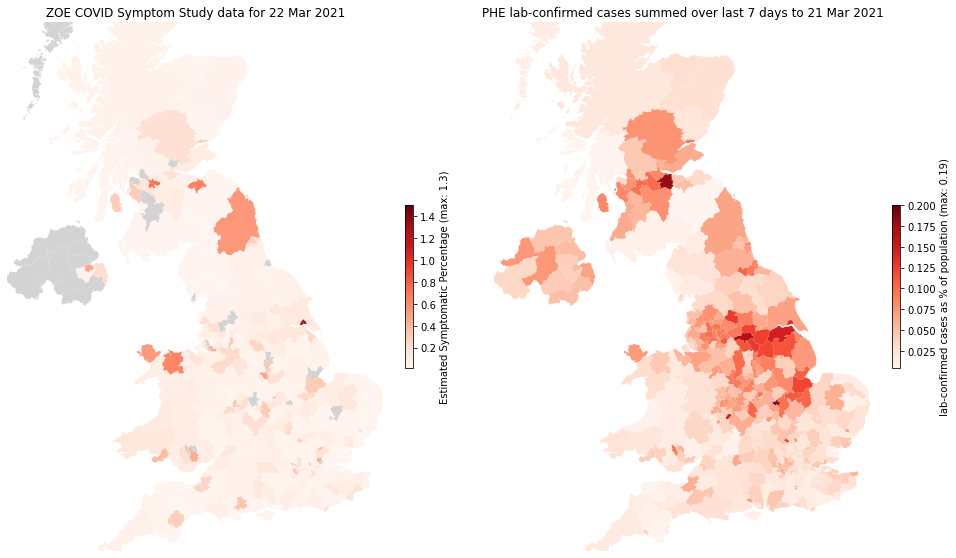

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

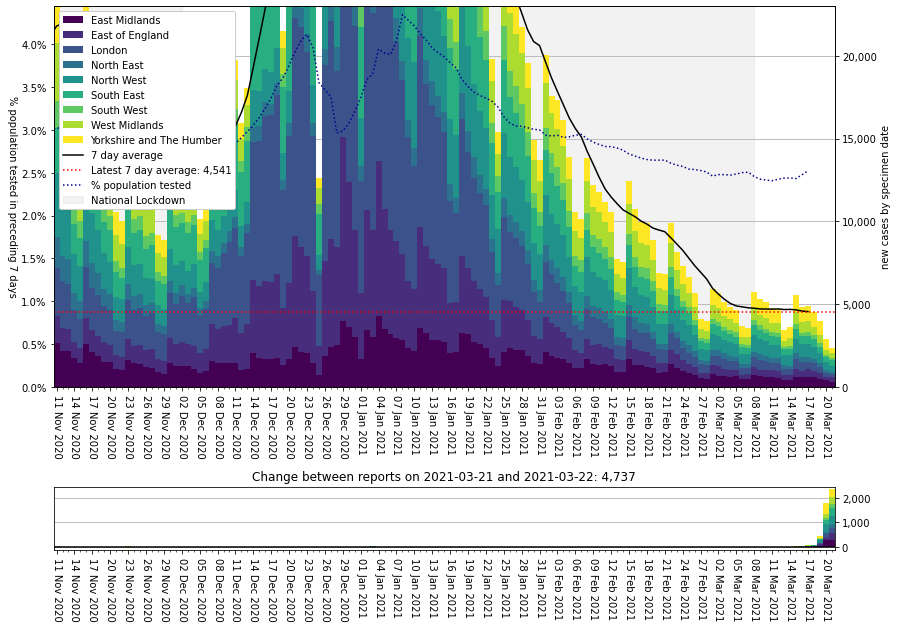

In [16]:
plot_areas(for_date, area_type=region, ylim=23_000, earliest='2020-11-11')

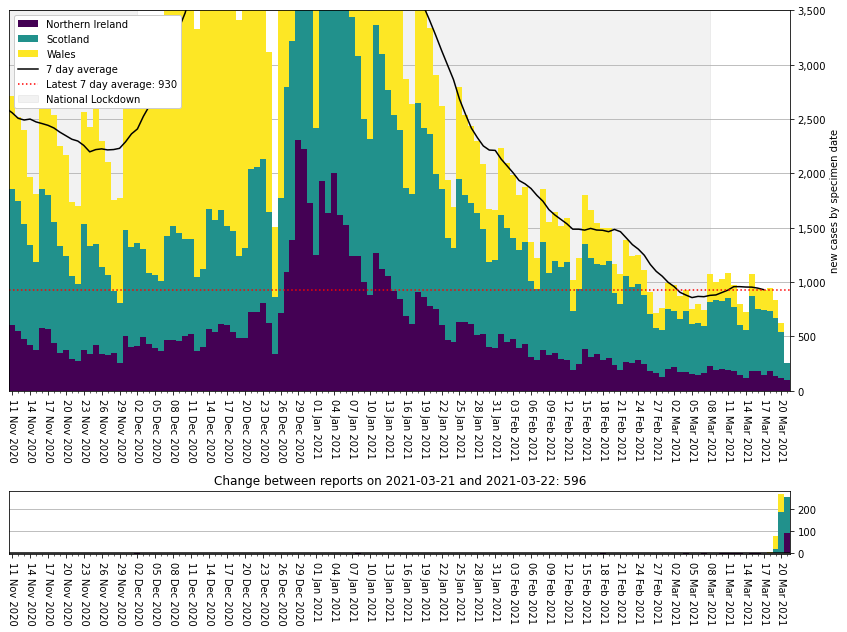

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=3_500, diff_ylims=None, earliest='2020-11-11')